# How to perform aperture photometry with custom apertures?

We have discussed in [previous tutorials](http://lightkurve.keplerscience.org/tutorials/1.03-what-are-lightcurves.html) how Simple Aperture Photometry works (SAP). We choose a set of pixels in the image and sum those to produce a single flux value. We sum the same pre-selected pixels for every image at each time slice to produce a light curve.

The [Kepler Data Pipeline](https://github.com/nasa/kepler-pipeline) produces an aperture, which is used by default by *Lightkurve*. However, there are some cases where you might want to produce your own aperture. The field may be crowded, or you may wish to change the aperture size to change the relative contribution of the background. K2 data generally needs larger apertures than the default pipeline mask.  Lightkurve offers tools to select pixels programmatically.

First, let's load a target pixel file. Let's choose Kepler planet canidate [KIC 6679295](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/DisplayOverview/nph-DisplayOverview?objname=KOI-2862.01&type=KEPLER_CANDIDATE). We'll use the [`search_targetpixelfile`](https://docs.lightkurve.org/api/lightkurve.search.search_targetpixelfile.html#lightkurve.search.search_targetpixelfile) function to download every target pixel file available for each quarter of this data set. 

In [2]:
%matplotlib inline
from lightkurve import search_targetpixelfile
import matplotlib.pyplot as plt

tpfs = search_targetpixelfile('KIC 6679295').download_all()
print(tpfs)

TargetPixelFileCollection of 14 objects:
	6679295 (14 KeplerTargetPixelFiles) Quarters: 4,5,6,7,8,9,10,11,12,13,14,15,16,17



We've now created a list of `KeplerTargetPixelFile` objects, where each object refers to a different quarter. We can go on to combine these objects via appending to a defined object, as shown below. 

In [4]:
# Build the light curve
pipeline_lc = tpfs[0].to_lightcurve().flatten()
for tpf in tpfs[1:]:
    pipeline_lc = pipeline_lc.append(tpf.to_lightcurve().flatten())
    
# Clean the light curve
pipeline_lc = pipeline_lc.remove_nans().remove_outliers()

Above we have created the light curve from the target pixel files and stitched them all together using the lightkurves `append` function. To recap the steps we follow:

* Convert to a `KeplerLightCurve` object with [`to_lightcurve()`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.KeplerTargetPixelFile.html#lightkurve.targetpixelfile.KeplerTargetPixelFile.to_lightcurve)
* Remove NaNs with [`remove_nans()`](https://docs.lightkurve.org/api/lightkurve.lightcurve.FoldedLightCurve.html#lightkurve.lightcurve.FoldedLightCurve.remove_nans)
* Remove long term trends with [`flatten()`](https://docs.lightkurve.org/api/lightkurve.lightcurve.FoldedLightCurve.html#lightkurve.lightcurve.FoldedLightCurve.flatten)
* Remove outliers with simple sigma clipping using [`remove_outliers()`](https://docs.lightkurve.org/api/lightkurve.lightcurve.FoldedLightCurve.html#lightkurve.lightcurve.FoldedLightCurve.remove_outliers)

This planet candidate has a period of 24.57537 days. Let's plot it up and take a look using the [`fold`](https://docs.lightkurve.org/api/lightkurve.lightcurve.FoldedLightCurve.html#lightkurve.lightcurve.FoldedLightCurve.fold) function which required both period on which to fold and the time corresponding to the zero phase.

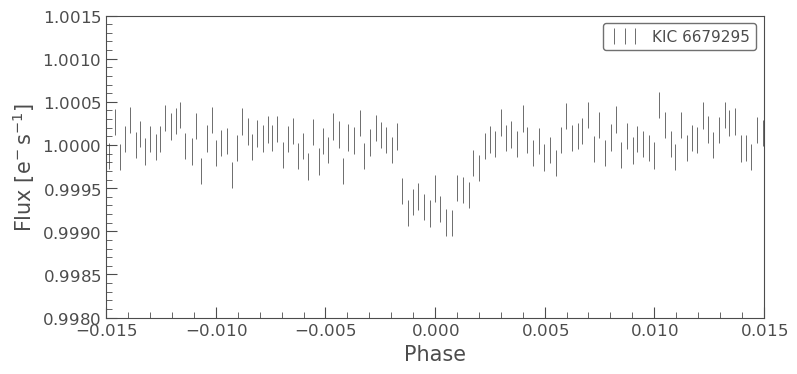

In [5]:
pipeline_lc.fold(period=24.57537, t0=21.3).bin().errorbar()
plt.xlim(-0.015, 0.015)
plt.ylim(0.998, 1.0015);

Looks like a great candidate. However, we might just want to check on the pixels. Let's plot one of the target pixel files.

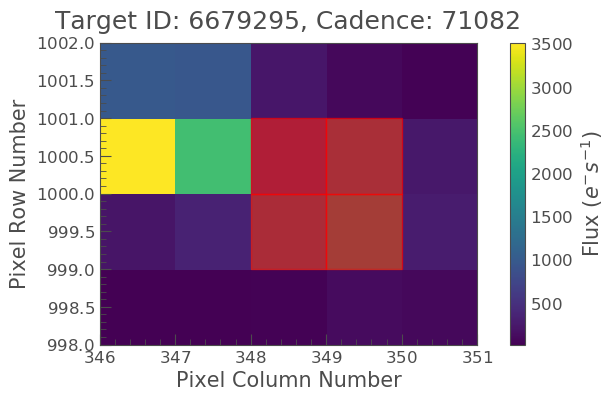

In [6]:
tpf.plot(frame=100, aperture_mask=tpf.pipeline_mask, mask_color='red');

The Kepler Pipeline aperture is in red. It looks like there is a nearby contaminate star! We might want to check that the signal is not really coming from the bright, nearby contaminant, rather than our target star. Let's use the top right corner four pixels as our new mask.

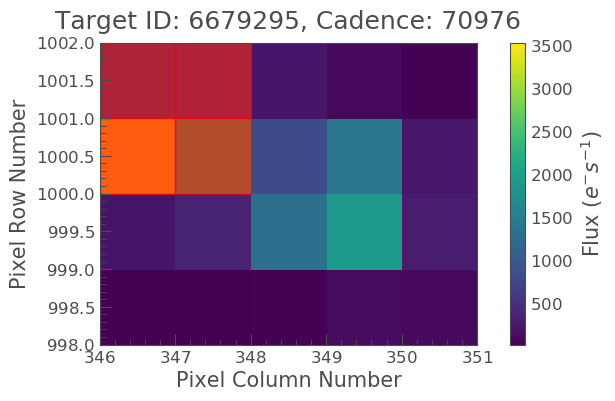

In [27]:
import numpy as np
aper = np.zeros(tpf.shape[1:], dtype=np.int)
aper[2:, :2] = 1
tpf.plot(aperture_mask=aper, mask_color='red');

The new mask covers the bright star. Now we can iterate through the target pixel files and build the light curve in the same way as before, but this time focusing on the bright star.

In [28]:
# Build the NEW aperture, and the light curve
aper = np.zeros(tpfs[0].shape[1:])
aper[2:, 0:2] = 1
user_lc = tpfs[0].to_lightcurve(aperture_mask=aper.astype(bool)).flatten()
for tpf in tpfs[1:]:
    aper = np.zeros(tpf.shape[1:])
    aper[2:, 0:2]=1
    user_lc = user_lc.append(tpf.to_lightcurve(aperture_mask=aper.astype(bool)).flatten())

# Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers()

Now we have our new light curve we can plot it up again and find out if there is still a planet signal. Lets use the same fold paramters as before.

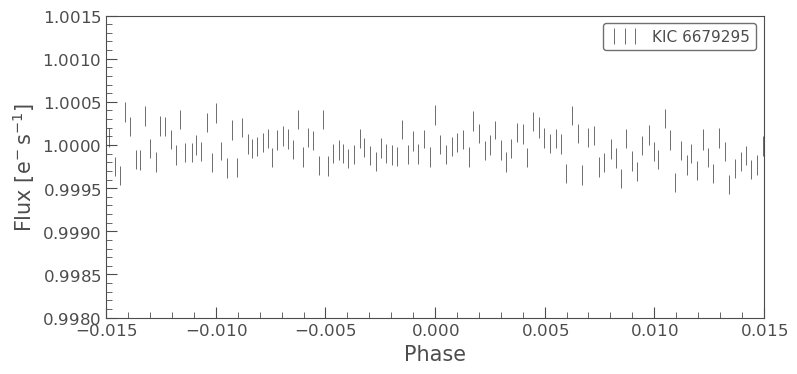

In [33]:
user_lc.fold(period=24.57537, t0=21.3).bin().errorbar()
plt.xlim(-0.015, 0.015)
plt.ylim(0.998, 1.0015);

Looks like the planet signal is only in the target star and doesn't belong to the contaminant. This is just one of many checks you might want to perform to validate your planet candidates!